# 載入一些套件與基本宣告

In [1]:
%pylab inline
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import string
import codecs
import os

import jieba
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import naive_bayes as bayes
from sklearn.model_selection import train_test_split
#簡轉繁
from hanziconv import HanziConv

#ham與spam的每封郵件list
ham_text = []
spam_text = []
#ham與spam的數據集
ham_data = []
spam_data = []
#取得目前工作目錄
SaveDirectory = os.getcwd() 
#獲得文檔列表
listham = os.listdir(SaveDirectory+'\\data\\normal')
listspam = os.listdir(SaveDirectory+'\\data\\spam')
#數據集數量

print('spam total：',len(listspam))
print('ham total：',len(listham))


Populating the interactive namespace from numpy and matplotlib
spam total： 7775
ham total： 7063


# 將ham文本資料轉成繁體並存成DATAFrame

In [2]:
for fileName in listham:
        with open('data/normal/'+fileName, 'r',encoding='gbk') as f:
            #文本每一列儲存
            text=[]
            # 過濾非中文字符，正規化
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]') #正規化(去除非中文字符)
                line = pattern.sub("", line) #將其他字符取代為""
                content = line.strip().split() #去除一些空白.換行
                text = text+content #儲存這個文本的內容
            text = " ".join(text) #將文本內容list加入全部文本的list
            ham_text.append(HanziConv.toTraditional(text)) #簡轉繁
ham_data = pd.DataFrame(ham_text,columns=['text']) #將list改成dataframe
ham_data['label']='0' #將資料類別加上 0:ham 1:spam
ham_data.head()


,text,label
0,這事兒還有續集 因為我姐她們買房子後來裝修的時候沒錢她婆婆他們就贊助瞭萬塊 這下一吵她婆婆就...,0
1,越發覺得這個姐夫不錯瞭 那萬還是趕緊還瞭吧 標題姐姐快要生孩子瞭很感慨 發信站水木社區站內 ...,0
2,或許某些農村吧 在一個當性彆勞動力富裕程度的地方還是可以理解的 標題姐姐快要生孩子瞭很感慨 ...,0
3,最近經常看到你說一些很武斷的話 所謂保胎確實是要躺在床上不能動的尤其是先兆流産有齣血的時候 ...,0
4,他們分手是說性格不閤 沒多久然後我們交往 還算比較愉快 當初因為他經常和聯係我曾跟他吵過多次...,0


# 將spam文本資料轉成繁體並存成DATAFrame

In [3]:
for fileName in listspam:
        with open('data/spam/'+fileName, 'r',encoding='gbk') as f:
            text=[]
            # 过滤掉非中文字符
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]')
                line = pattern.sub("", line)
                content = line.strip().split()
                text = text+content
            text = " ".join(text)
            spam_text.append(HanziConv.toTraditional(text))
spam_data = pd.DataFrame(spam_text,columns=['text'])
spam_data['label']='1'
spam_data.head()

,text,label
0,會員注冊邀請書 全國最低價域名空間大放送 國際頂級域名注冊驚暴價元年元年連續注冊年以上 國傢...,1
1,你好 以茶會友以茶聯誼喝茶就喝安溪鐵觀音 本廠是專業生産批發各等級鐵觀音茶葉的購買聯係 在綫...,1
2,尊敬的先生小姐 您好 首先感謝您抽時間查看以下信息 我公司一直緻力於研發生産銷售施工環氧樹脂...,1
3,先生 你好 批發麻醉藥催情藥墮胎藥避孕藥飲料型噴霧型香煙型揮發型等各類國際國內製藥企業推齣的...,1
4,貴公司負責人經理財務您好 我是深圳市創偉實業有限公司的我司實力雄厚有著良 好的社會關係也有部...,1


# 將ham與spam組合並打亂

In [4]:
all_data = pd.concat([spam_data,ham_data],axis=0, ignore_index=True)  #將ham lsit與spam list串起來
all_data = all_data.sample(frac=1).reset_index(drop=True) #sample frac = 1 是把數據都打亂 resr_index是把index也重設
print('data shape：',all_data.shape)
print('spams in rows：',all_data.loc[all_data['label']=="1"].shape[0])
print('hams in rows：',all_data.loc[all_data['label']=="0"].shape[0])
all_data.head(6)

data shape： (14838, 2)
spams in rows： 7775
hams in rows： 7063


,text,label
0,尊敬的公司工廠經理負責人你好 我公司是一傢多年為外資企業代理進齣口業務的公司現有部分稅額如增...,1
1,彆急一切會好的我第一份工作辭瞭之後又小半年沒找到工作不是一樣熬過來瞭 基督山伯爵最後一句話說...,0
2,這種事情好歹要與商量一下的畢竟是人傢那邊的親人 未婚的女子還不知柴米油鹽貴適當地聊聊就好瞭沒...,0
3,尊敬的公司財務負責人 您好深圳市聲威實業有限公司我公司在全國大中城市設有分公司因進項 較多現...,1
4,這也是一部英國電影最近好像英國齣品的好電影不少 一對律師搭檔好像是高中同學其中一個好像是這個...,0
5,貴公司負責人經理財務您好 我是深圳市金利嘉實業有限公司因全國各地分公司的進項較多現完成不瞭每...,1


# 載入停用詞

In [5]:
#載入 停用詞 (stopwords) 自動過濾掉某些字或詞
stopwords = codecs.open(os.path.join(SaveDirectory+'\data', 'stopwords_tr.txt'), 'r', 'utf-8').read().split('\r\n')

# 將文本利用Jieba斷詞、過濾停用詞

In [6]:
processed_texts = []
for text in all_data["text"]:
    words = []
    seg_list = jieba.cut(text) #利用Jieba斷詞
    for seg in seg_list: 
        # isalpha()檢測詞是否由字符組成，且不在停用詞的list中
        if (seg.isalpha()) & (seg not in stopwords):
            words.append(seg)
    sentence = " ".join(words)
    processed_texts.append(sentence)
all_data["text"] = processed_texts #利用過濾且斷好的詞取代文本
all_data.head(6)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zxc98\AppData\Local\Temp\jieba.cache
Loading model cost 0.577 seconds.
Prefix dict has been built succesfully.


,text,label
0,尊敬 公司 工廠 經理 負責人 你好 公司 傢 多年 外資 企業 代理 進 齣 口業務 公司...,1
1,彆 急 好 第一份 工作 辭 瞭 後 小 半年 找到 工作 熬 過來 瞭 基督山 伯爵 最 ...,0
2,這種 事情 好歹 商量一下 畢 竟是 人 傢 親人 未婚 女子 不知 柴米 油鹽貴 適當 聊...,0
3,尊敬 公司 財務 負責人 您好 聲威 實業 有限公司 公司 全國 大中城市 設有 分公司 因...,1
4,這也 一部 英國 電影 最近 好像 英國 齣 品 好 電影 一對律師 搭 檔 好像 高中 同...,0
5,公司 負責人 經理 財務 您好 金利 嘉實業 有限公司 因全國 各地 分公司 進項 多現 完...,1


# 3. 計算HAM和SPAM 的 TF-IDF差異 DIFF
## 值越大的代表他在SPAM的可能性更大
「size_table」: 要選多少個重要的「詞」出來，等於決定特徵向量的維度數。Default:我設成200。 「ignore」: 字少於幾個以下就不要算

In [7]:
import re
def generate_key_list(all_data, size_table=200,ignore=2):
    dict_spam_raw = dict()
    dict_genuine_raw = dict()
    dict_IDF = dict()

    # 去除字母外的所有內容.
    for i in range(all_data.shape[0]):
        finds = all_data.iloc[i].text.split(" ")
        if all_data.iloc[i].label == '1':
            for find in finds:
                if len(find)<ignore: continue
                try:
                    dict_spam_raw[find] = dict_spam_raw[find] + 1
                except:	
                    dict_spam_raw[find] = dict_spam_raw.get(find,1) #若是新的文字因為後面get找不到這個索引會返回逗點後面的值
                    dict_genuine_raw[find] = dict_genuine_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                try:
                    dict_genuine_raw[find] = dict_genuine_raw[find] + 1
                except:	
                    dict_genuine_raw[find] = dict_genuine_raw.get(find,1)
                    dict_spam_raw[find] = dict_spam_raw.get(find,0)

        word_set = set()
        for find in finds:
            if not(find in word_set):
                if len(find)<ignore: continue
                try:
                    dict_IDF[find] = dict_IDF[find] + 1
                except:	
                    dict_IDF[find] = dict_IDF.get(find,1)
            word_set.add(find)
    word_df = pd.DataFrame(list(zip(dict_genuine_raw.keys(),dict_genuine_raw.values(),dict_spam_raw.values(),dict_IDF.values())))
    word_df.columns = ['keyword','genuine','spam','IDF']
    word_df['genuine'] = word_df['genuine'].astype('float')/all_data[all_data['label']=='0'].shape[0]
    word_df['spam'] = word_df['spam'].astype('float')/all_data[all_data['label']=='1'].shape[0]
    word_df['IDF'] = np.log10(word_df.shape[0]/word_df['IDF'].astype('float'))
    word_df['genuine_IDF'] = word_df['genuine']*word_df['IDF']
    word_df['spam_IDF'] = word_df['spam']*word_df['IDF']
    word_df['diff']=word_df['spam_IDF']-word_df['genuine_IDF']
    selected_spam_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    i = 0
    for word in selected_spam_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict   
# build a tabu list based on the training data
size_table = 200               # 多少特徵維度去分類SPAM
word_len_ignored = 2            # 忽略那些比這個還要小的字詞
keyword_dict=generate_key_list(all_data, size_table, word_len_ignored)

In [8]:
#排序越前面的代表出現在SPAM的機率越大
for key,value in keyword_dict.items():
    print('{key}:{value}'.format(key = key, value = value))

公司:0
發票:1
有限公司:2
實業:3
我司:4
每月:5
左右:6
貴司:7
銷售:8
您好:9
額度:10
信息:11
廣告:12
增值:13
優惠:14
經理:15
代理:16
財務:17
負責人:18
運輸:19
商祺:20
順祝:21
數量:22
進項:23
點數:24
鄭重:25
詳情:26
網站:27
大小:28
分公司:29
服務:30
承諾:31
優惠代開:32
電話:33
所用:34
普通:35
完成:36
商品:37
抵扣:38
真票:39
企業:40
郵箱:41
雄厚:42
有效:43
直接:44
一部分:45
可上:46
實力:47
多現:48
郵件:49
閤作:50
社會關:51
洽商:52
廣州:53
業務:54
稅務局:55
地址:56
商討:57
永久:58
如須:59
地稅:60
付款:61
稅電腦:62
疑慮:63
普通商品:64
一步:65
歡迎:66
國稅:67
客戶:68
有著:69
核對:70
如貴司:71
手機:72
網查證:73
現有:74
良好:75
低還:76
東莞:77
免費:78
擔心:79
數較:80
作點:81
管理:82
銷售稅:83
電小時:84
提供:85
外代:86
注冊:87
海關:88
軟件:89
繳款:90
機會:91
代開:92
網絡:93
電腦:94
專用:95
搜索:96
尊敬:97
能夠:98
建築:99
查詢:100
全國:101
先生:102
一次:103
售額度:104
稅務:105
資料:106
金利:107
成立:108
嘉實業:109
傳真:110
中心:111
票據:112
使用:113
多年:114
支持:115
功能:116
各地:117
部分:118
名稱:119
電子:120
形象:121
地坪:122
所開:123
發布:124
最新:125
網址:126
群發:127
你好:128
電腦版:129
希望:130
代辦:131
設計:132
牢固:133
建築安裝:134
樹立:135
以誠信:136
服務業:137
州市:138
服務廣告:139
請電:140
來電:141
單據:142
進倉:143
價格:144
設備:145
貿易:146
核心思想:147
稅率:148
堅持:149
設有:150
優惠代:151
印刷:152
如有:153
局驗證:

# 將原本斷詞好的數據轉用TFIDF所過濾出來的詞轉換成稀疏矩陣

In [9]:
def convert_Content(text, keyword_dict):
    #判斷是否有此特徵
    m = len(keyword_dict) #維度數量
    res = np.int_(np.zeros(m)) #建置一個幾維度的向量
    finds = text.split(" ") #將文本內容切割(類似中文斷詞)
    for find in finds:
        try:
            #若比對完有此特徵則特徵改為1
            i = keyword_dict[find] 
            res[i]=1
        except:
            continue
    return res
def raw2feature(all_data,keyword_dict):
    n_all_data = all_data.shape[0]
    m = len(keyword_dict)
    X_all_data = np.zeros((n_all_data,m));
    Y_all_data = np.int_(all_data.label=='1')
    for i in range(n_all_data):
        X_all_data[i,:] = convert_Content(all_data.iloc[i].text, keyword_dict)
    return [X_all_data,Y_all_data]
     
all_data_matrix=raw2feature(all_data,keyword_dict)


# 利用交叉驗證方式將數據切成訓練集與測試集

In [10]:
#traindate & testdata
train_set, test_set, trainlabel, testlabel = train_test_split(all_data_matrix[0], all_data_matrix[1], test_size = 0.15)
train_set

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
print("train:"+str(len(train_set)))
print("test:"+str(len(test_set)))
print(sum(trainlabel))
print(sum(testlabel))

train:12612
test:2226
6635
1140


# 下面是傳統監督式NB.RF的方法

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
def learn(train,trainlabel):
    model_NB = GaussianNB(priors=None)
    model_NB.fit(train_set, trainlabel)
    Y_hat_NB = model_NB.predict(train_set)

    model_RF = RandomForestClassifier(n_estimators=200, max_depth=None,\
                                 min_samples_split=2, random_state=0)
    model_RF.fit(train_set, trainlabel)
    Y_hat_RF = model_RF.predict(train_set)
    
    n=np.size(trainlabel)
    print('Training Accuarcy NBclassifier : {:.2f}％'.format(sum(np.int_(Y_hat_NB==trainlabel))*100./n))
    print('Training Accuarcy RF: {:.2f}％'.format(sum(np.int_(Y_hat_RF==trainlabel))*100./n))
    return model_NB,model_RF
# train the Random Forest and the Naive Bayes Model using training data
model_NB,model_RF=learn(train_set,trainlabel)

Training Accuarcy NBclassifier : 90.14％
Training Accuarcy RF: 97.59％


In [13]:
def test_func(test,testlabel,model):
    Y_hat = model.predict(test)
    n=np.size(testlabel)
    print ('Testing Accuarcy: {:.2f}％ ({})'.format(sum(np.int_(Y_hat==testlabel))*100./n,model.__module__))
# Test Model using testing data
test_func(test_set,testlabel,model_NB)
test_func(test_set,testlabel,model_RF)


Testing Accuarcy: 89.85％ (sklearn.naive_bayes)
Testing Accuarcy: 96.50％ (sklearn.ensemble.forest)


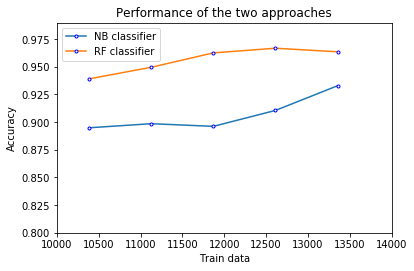

In [14]:
import matplotlib.pyplot as plt

x = [10386, 11128, 11870, 12612,13354]
y = [0.8949, 0.8986, 0.8962, 0.9106,0.9329]
y1 = [0.9391, 0.9496, 0.9626, 0.9668,0.9636]
plt.xlim(10000, 14000)
plt.ylim(0.8, 0.99)
plt.plot(x, y, marker='.', mec='b', mfc='w' )
plt.plot(x, y1, marker='.', mec='b', mfc='w' )
plt.legend([
    'NB classifier', 
    'RF classifier'
])  # 让图例生效
# plt.xticks(x, names, rotation=45)
plt.margins(0)
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"Train data") #X轴标签
plt.ylabel("Accuracy") #Y轴标签
plt.title("Performance of the two approaches") #标题
plt.savefig("classifier ")
plt.show()

# 下面是測試PU

In [15]:
import pandas as pd #數據處理
import numpy as np  #隨機取數
import matplotlib.pyplot as plt   #繪圖
#把繪圖套入ipython中的魔法函數%
%matplotlib inline  
plt.rcParams['figure.figsize'] = 7,7   # 圖片大小
plt.rcParams['font.size'] = 14         # 圖片文字大小

## 載入上面數據集

In [16]:
trainlabel_ = trainlabel.tolist()
trainlabel_ = pd.Series(trainlabel_)
train_set_ = train_set.tolist()
train_set_ = pd.DataFrame(train_set_)
sum(trainlabel_)


6635

## 隱藏9成的數據集

In [17]:
# 保留原本的標籤，之後比對使用
trainlabel_orig = trainlabel.copy()

# 取消一些標記的數據
hidden_size = 5936
#loc可以選擇數據(把上面數量的POSTIVE DATA隱藏為UNLABELED DATA)
trainlabel_.loc[
    np.random.choice(
        trainlabel_[trainlabel_ == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

## 使用基本的監督式隨機森林法來計算概率

In [ ]:
# 使用一般的隨機森林算法
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
rf.fit(train_set, trainlabel_)

# 儲存次方法給定的分數
results = pd.DataFrame({
    'truth'      : trainlabel_orig,   # 真實標籤
    'label'      : trainlabel_,        # 預測標籤
    'output_std' : rf.predict_proba(train_set)[:,1],   # 隨機森林分數(求屬於標籤1的概率)
}, columns = ['truth', 'label', 'output_std'])
# print(results)

## PU-Bagging
### 1.他是透過將正實例和未標記實例結合創建數據集，並進行替換
### 2.將正數視為正實例，負數視為未標記實例
### 3.將分類器應用於隨機樣本中未包含的人合未標記數據點，稱為OOB(out of bag)，並記錄其分數
### 重複上面三個步驟，最後每個點OOB分數為每次分配分數的平均值

#### 原本是決策樹但校果不好改隨機森林

In [ ]:
X = train_set_
y = trainlabel_
# 使用1000棵決策樹
# from sklearn.tree import DecisionTreeClassifier
nestimators = 1000
# estimator = DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
# 追蹤正實例和未標記實例的索引
iP = y[y > 0].index
iU = y[y <= 0].index

# 對每個數據點記錄他是OOB的次數
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# 記錄OOB分數的總合
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(nestimators):
    # 獲取本輪未標記點的 bootstrap sample(引導樣本)
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # 找到本輪的OOB數據
    i_oob = list(set(iU) - set(ib))

    # 獲取訓練數據 (所有正實例和 bootstrap sample(未標記實例)還有建立樹
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # 紀錄本輪OOB分數還有OOB次數
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# 最後儲存平均的OOB分數
results['output_bag'] = sum_oob / num_oob
print(results)

In [ ]:
X.loc[ib].shape

In [ ]:
ts = range(3936, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )
#     y_skb.append(
#         results[results.label == 0].sort_values(
#             'output_skb', ascending = False
#         ).head(t).truth.mean()
#     )
#     y_stp.append(
#         results[results.label == 0].sort_values(
#             'output_stp', ascending = False
#         ).head(t).truth.mean()
#     )
#     y_all.append(
#         results[results.label == 0].sort_values(
#             'output_all', ascending = False
#         ).head(t).truth.mean()
#     )

# 提取RN跟P在訓練一個新分類器

In [ ]:
positiveX = results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).index
trainlabel_.loc[positiveX[:5936]] = 1
from sklearn.ensemble import RandomForestClassifier
purf = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
purf.fit(train_set, trainlabel_)
trainlabel_.loc[positiveX[:5936]] = 0

In [ ]:
positiveXpos = results[results.label == 1].index
positiveXneg = results[results.label == 0].sort_values('output_std', ascending = True).index
positiveXpos = trainlabel_.loc[positiveXpos[:]]
positiveXneg = trainlabel_.loc[positiveXneg[:653]]
positiveXlabel = positiveXpos+positiveXneg

from sklearn.ensemble import RandomForestClassifier
purfposneg = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
purfposneg.fit(train_set[positiveXlabel.index], trainlabel_[positiveXlabel.index])

# --------------------------------------------------

In [ ]:
positiveXpu = results[results.label == 0].sort_values('output_bag', ascending = False).index
trainlabel_.loc[positiveXpu[:5936]] = 1
from sklearn.ensemble import RandomForestClassifier
pubaggingrf = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
pubaggingrf.fit(train_set, trainlabel_)
trainlabel_.loc[positiveXpu[:5936]] = 0

In [ ]:
# 效能圖
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    #ts, y_stp,
    #ts, y_all,
    lw = 5
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier',
    'PU bagging',
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()

# 下面是實驗

In [ ]:
def test_func(test,testlabel,model):
    Y_hat = model.predict(test)
    n=np.size(testlabel)
    print ('Testing Accuarcy: {:.2f}％ ({})'.format(sum(np.int_(Y_hat==testlabel))*100./n,model.__module__))
# Test Model using testing data
test_func(test_set,testlabel,rf) #傳統監督式
test_func(test_set,testlabel,purf) #PU提出後的改良版
test_func(test_set,testlabel,pubaggingrf)
test_func(test_set,testlabel,purfposneg)

In [ ]:
ts = range(100, hidden_size, 200)
y_std = []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )

# 以下是將測試集導入

In [ ]:
test_text = []
testspam_text = []
testham_text = []
test_data = []
listtest = os.listdir(SaveDirectory+'\\data\\test')

In [ ]:
for fileName in listtest:
    if int(fileName)>1000:
        with open('data/test/'+fileName, 'r',encoding='gbk') as f:
            #文本每一列儲存
            text=[]
            # 過濾非中文字符，正規化
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]') #正規化(去除非中文字符)
                line = pattern.sub("", line) #將其他字符取代為""
                content = line.strip().split() #去除一些空白.換行
                text = text+content #儲存這個文本的內容
            text = " ".join(text) #將文本內容list加入全部文本的list
            testspam_text.append(HanziConv.toTraditional(text)) #簡轉繁
    else:
        with open('data/test/'+fileName, 'r',encoding='gbk') as f:
            #文本每一列儲存
            text=[]
            # 過濾非中文字符，正規化
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]') #正規化(去除非中文字符)
                line = pattern.sub("", line) #將其他字符取代為""
                content = line.strip().split() #去除一些空白.換行
                text = text+content #儲存這個文本的內容
            text = " ".join(text) #將文本內容list加入全部文本的list
            testham_text.append(HanziConv.toTraditional(text)) #簡轉繁
        
            
testspam_data = pd.DataFrame(testspam_text,columns=['text']) #將list改成dataframe
testham_data = pd.DataFrame(testham_text,columns=['text']) #將list改成dataframe
testspam_data['label']='1' #將資料類別加上 0:ham 1:spam
testham_data['label']='0'
test_data = pd.concat([testspam_data,testham_data])
test_data = test_data.sample(frac=1).reset_index(drop=True)
test_data.head()


In [ ]:
processed_texts = []
for text in test_data["text"]:
    words = []
    seg_list = jieba.cut(text) #利用Jieba斷詞
    for seg in seg_list: 
        # isalpha()檢測詞是否由字符組成，且不在停用詞的list中
        if (seg.isalpha()) & (seg not in stopwords):
            words.append(seg)
    sentence = " ".join(words)
    processed_texts.append(sentence)
test_data["text"] = processed_texts #利用過濾且斷好的詞取代文本
test_data.head(6)

In [ ]:
test_data_matrix=raw2feature(test_data,keyword_dict)
test_testset = test_data_matrix[0]
test_testlabel = test_data_matrix[1]

In [ ]:
def test_func(test,testlabel,model):
    Y_hat = model.predict(test)
    n=np.size(testlabel)
    print ('Testing Accuarcy: {:.2f}％ ({})'.format(sum(np.int_(Y_hat==testlabel))*100./n,model.__module__))
# Test Model using testing data
test_func(test_testset,test_testlabel,rf)
test_func(test_testset,test_testlabel,model_RF)
test_func(test_testset,test_testlabel,pubaggingrf)
test_func(test_testset,test_testlabel,purfposneg)